# Networkx and Altair

In [1]:
%matplotlib inline
import numpy as np
import networkx as nx
import altair as alt
import altair_nx as anx

GitHub suppresses interactive charts (no JS is run), therefore the static image renderer below is ONLY meant for runs before before pushing.

Re-run without it for default (interactive) rendering.

In [2]:
# NOTE: NO CHART INTERACTIVITY IF UNCOMMENTED
# alt.renderers.enable('png', scale_factor = 1, ppi = 144) # docs for all renderers: https://altair-viz.github.io/user_guide/display_frontends.html

RendererRegistry.enable('png')

## Create a random network

In [3]:
# np.random.seed(42) # for reproducible results

n_nodes = 30

# Generate a random graph, directed or undirected
G = nx.fast_gnp_random_graph(n = n_nodes, p = 0.25)#, directed = True)

# Give self-loops to half of the nodes
G.add_edges_from([(int(n),int(n)) for n in np.random.default_rng().choice(n_nodes, size = n_nodes // 2, replace = False)])
    # Casting to int since numpy.int64 is not JSON serializable

# Add random attributes to nodes and edges
nx.set_node_attributes(G, {n: dict(importance = np.random.randn(), name = np.random.randint(1000), viable = np.random.choice(['yes', 'no'])) for n in G.nodes})
nx.set_edge_attributes(G, {e: dict(weight = np.random.uniform(1, 10), quality = np.random.choice(['good', 'bad'])) for e in G.edges})
    # set_*_attributes is convenient when setting multiple attributes; could set single ones manually: for e in G.edges(): G.edges[e]['weight'] = np.random.uniform(1, 10)

# Compute node positions (by default, layouts tend to use the 'weight' edge attribute if present)
pos = nx.spring_layout(G)

## Drawing the graph

First, draw it with NetworkX:


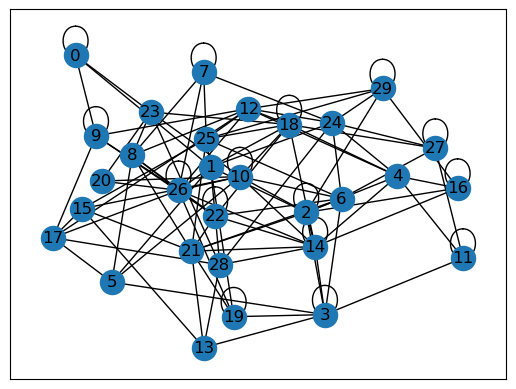

In [4]:
nx.draw_networkx(G, pos)

Next, draw an equivalent non-interactive representation with altair-nx:

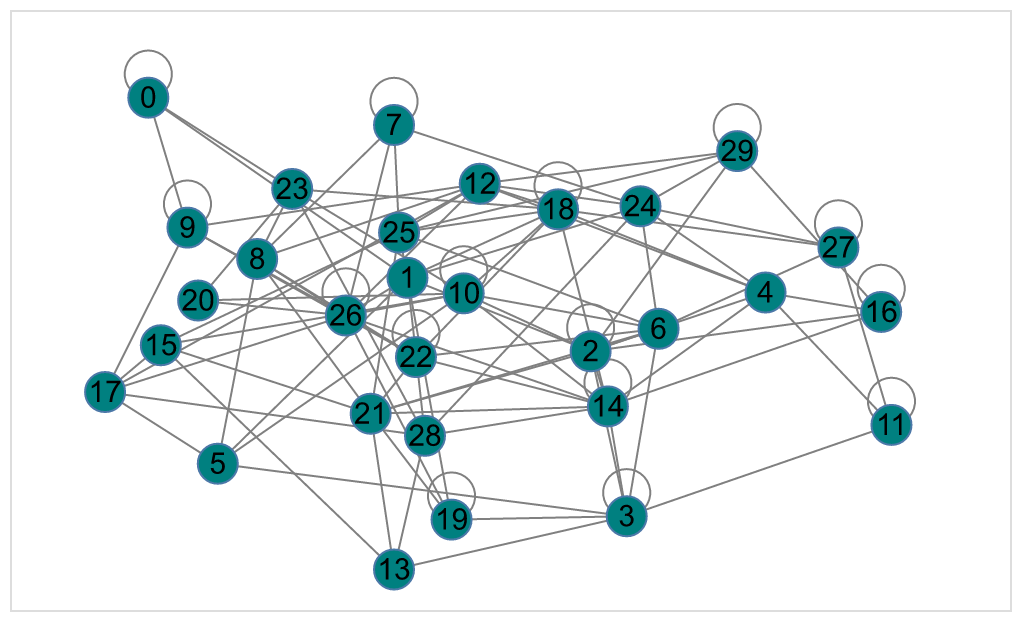

In [5]:
anx.draw_networkx(G, pos, node_label = 'node')

Then customise some basic chart properties and add a minimal level of interactivity (tooltips, zoom and panning):

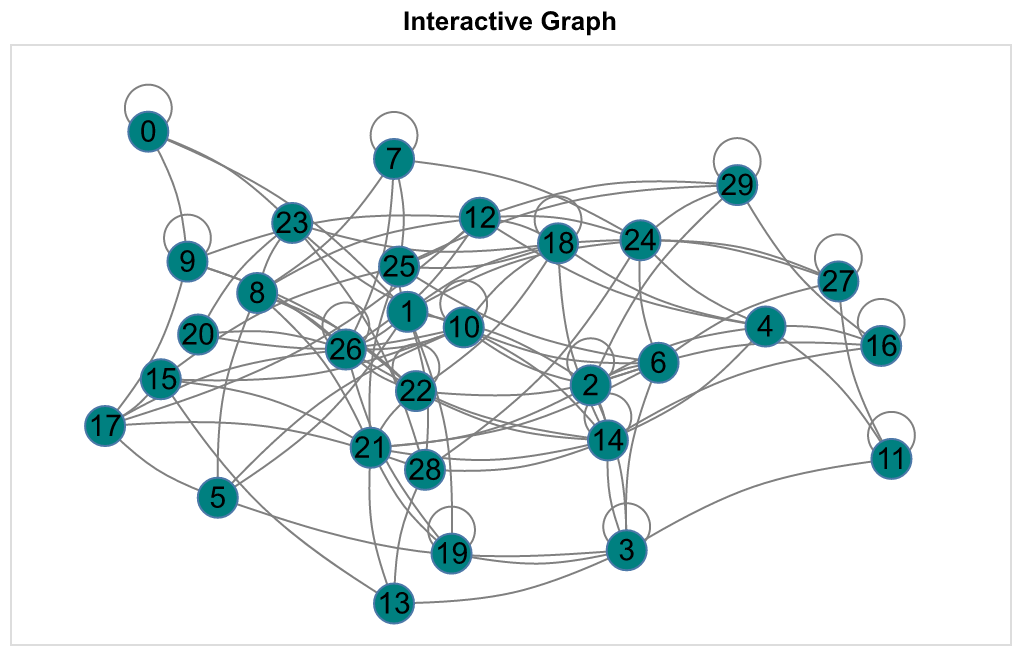

In [6]:
anx.draw_networkx(G, pos,
    node_label = 'node', node_tooltip = ['name', 'importance', 'viable'], curved_edges = True
).properties(title = 'Interactive Graph').interactive()

Finally, play around with all the arguments (your IDE will likely describe them on hover and show their default values by hovering on the function):

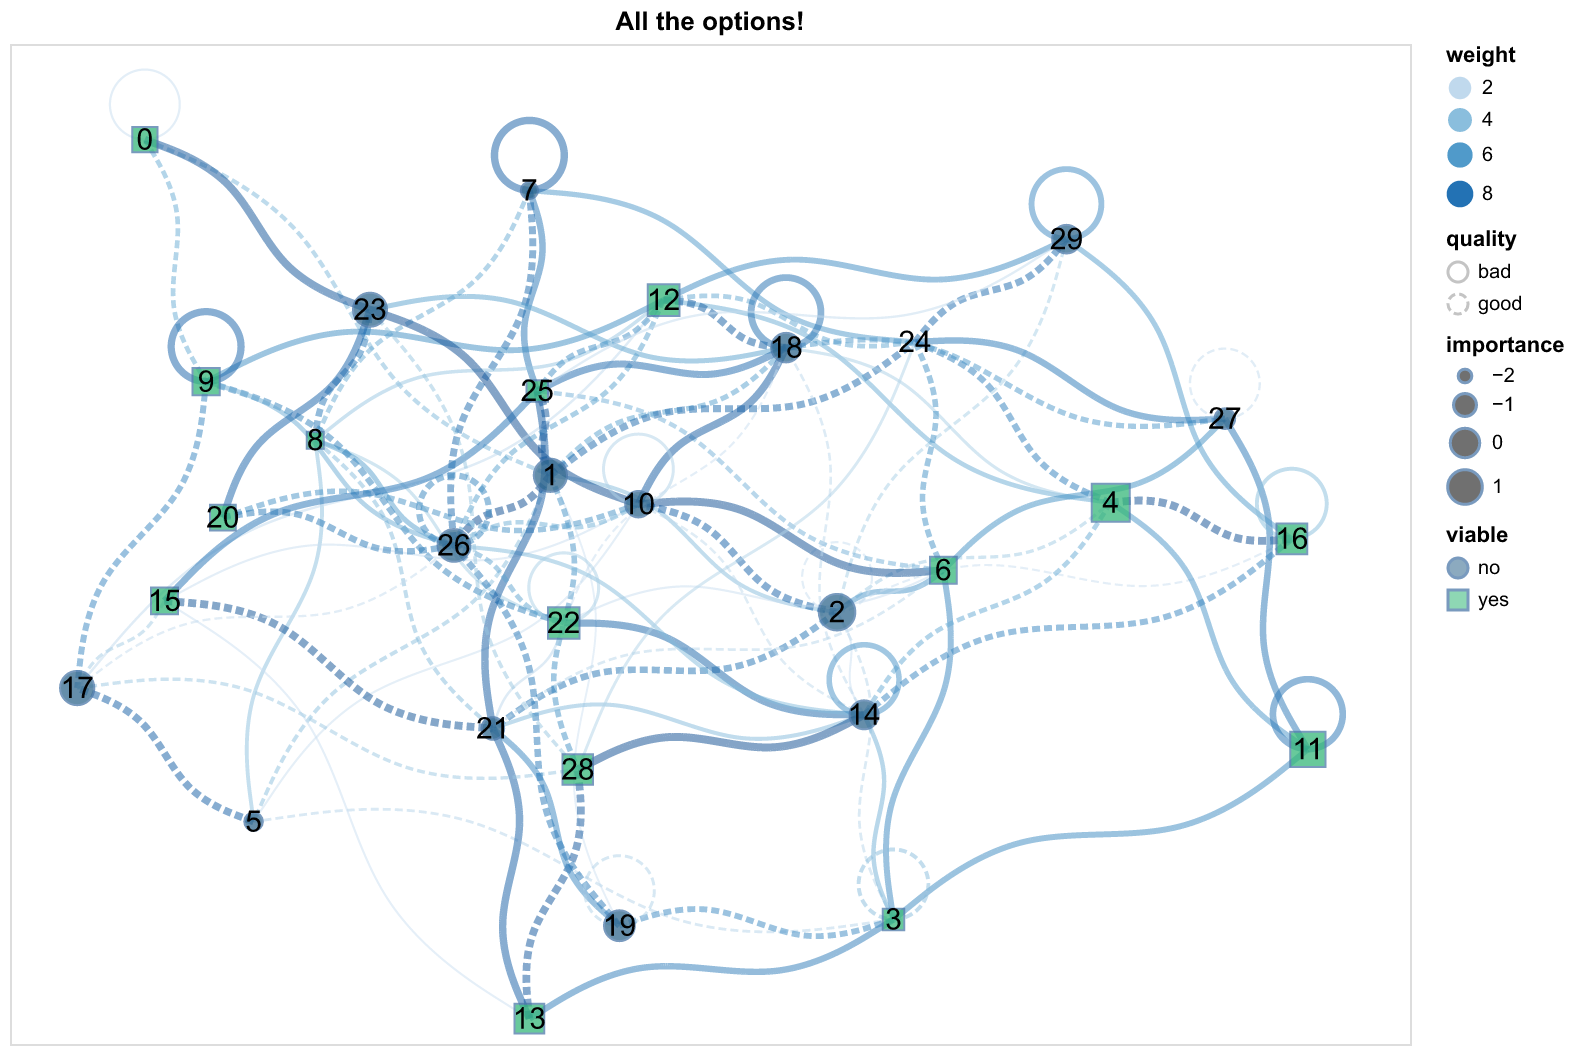

In [7]:
anx.draw_networkx(G, pos,
    node_subset = None, edge_subset = None, show_orphans = True, show_self_loops = True,
    node_size = 'importance', node_shape = 'viable', node_colour = 'viable', node_cmap = 'viridis', node_alpha = .75,
    node_outline_width = 1., node_outline_dash_and_gap_lengths = None, node_outline_colour = None,
    node_mark_kwargs = None, node_encode_kwargs = None, # direct altair access if the above node arguments are not enough
    node_label = 'node', node_font_size = 15, node_font_colour = 'black', node_tooltip = ['name', 'importance', 'viable'], node_legend = True,
    node_label_mark_kwargs = None, node_label_encode_kwargs = None, # direct altair access if the above node label arguments are not enough
    edge_width = 'weight', edge_dash_and_gap_lengths = 'quality', edge_colour = 'weight', edge_cmap = 'blues', edge_alpha = .5,
    edge_tooltip = ['pair', 'weight'], edge_legend = True,
    loop_radius = .04, loop_angle = 90., loop_n_points = 30,
    curved_edges = True, edge_control_points = [(0.333, 0.1), (0.666, -0.1)], edge_interpolation = 'basis',
    edge_mark_kwargs = None, edge_encode_kwargs = None, # direct altair access if the above edge arguments are not enough
    arrow_width = 2, arrow_length = .1, arrow_length_is_relative = True, arrow_colour = 'black', arrow_cmap = None, arrow_alpha = 1., arrow_legend = False,
    arrow_mark_kwargs = None, arrow_encode_kwargs = None, # direct altair access if the above arrow arguments are not enough
    chart_width = 700, chart_height = 500, chart_padding = .02
).properties(title = 'All the options!').interactive()

# Leveraging Altair for deeper interactivity

Make a chart depend on a selection over the graph:

In [8]:
chart = anx.draw_networkx(G, pos,
    node_size = 200, node_colour = 'viable', node_cmap = 'viridis', node_tooltip = ['importance', 'name', 'viable'],
    edge_width = 'weight'
)

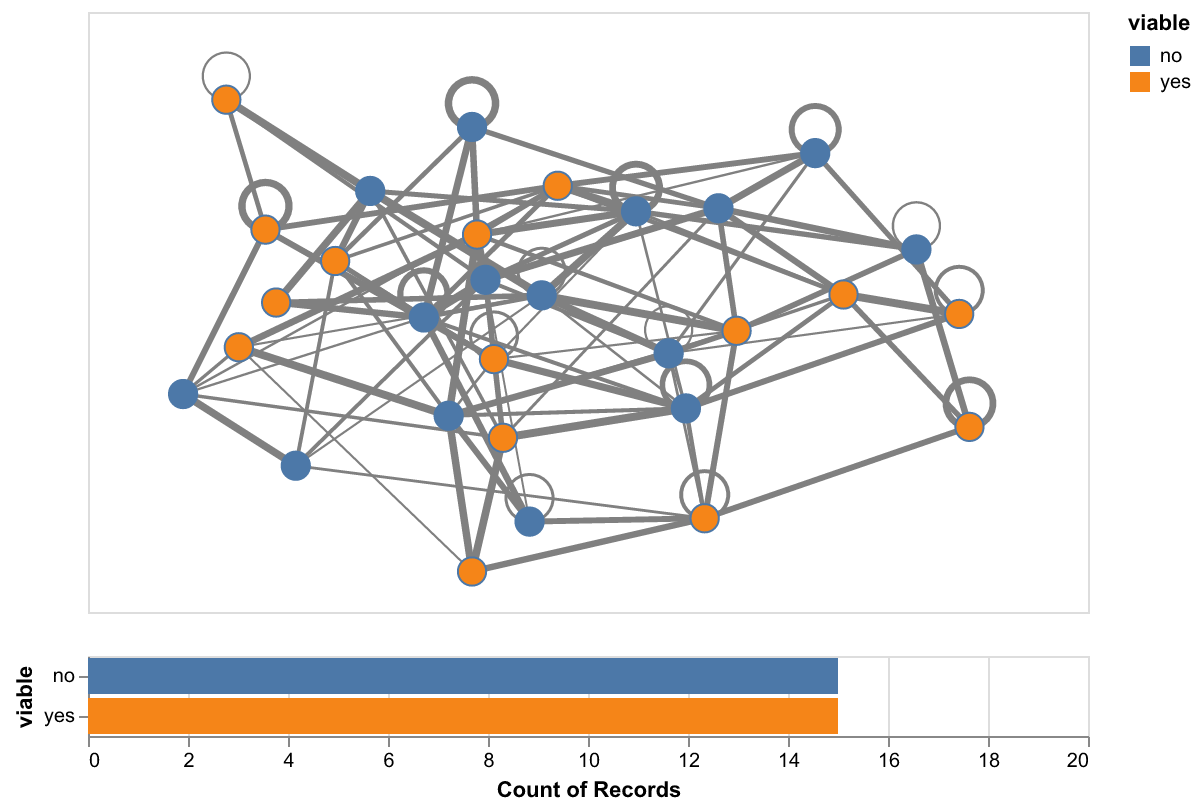

In [9]:
# Get the node layer
#   The possible layers are [edges, arrows, nodes, labels], in this order,
#   but arrows are present only if G is directed and labels only if node_label is not None.
nodes = chart.layer[-1] # Assuming no labels; fine with both directed and undirected G

# Build a brush
brush = alt.selection_interval(encodings = ['x', 'y'])
colour = alt.Color('viable:N', legend = None)

# Condition nodes based on brush
nodes = nodes.encode(
    fill = alt.condition(brush, colour, alt.value('gray')),
).add_params(brush)

# Create a bar graph to show highlighted nodes
bars = alt.Chart(nodes.data).mark_bar().encode(
    x = alt.X('count()').scale(domain = (0, 20)),
    y = 'viable',
    color = 'viable',
).transform_filter(brush)

# Recombine layers, copy size and axes' ranges, and combine vertically with bars
edges = chart.layer[0] + chart.layer[1] if G.is_directed() else chart.layer[0] # include arrows if present
graph_chart = anx.copy_size_and_axes(chart, edges + nodes) # maintain the original aspect ratio
graph_chart & bars.properties(width = graph_chart.width) # match widths and stack vertically

Create controls to affect chart parameters:

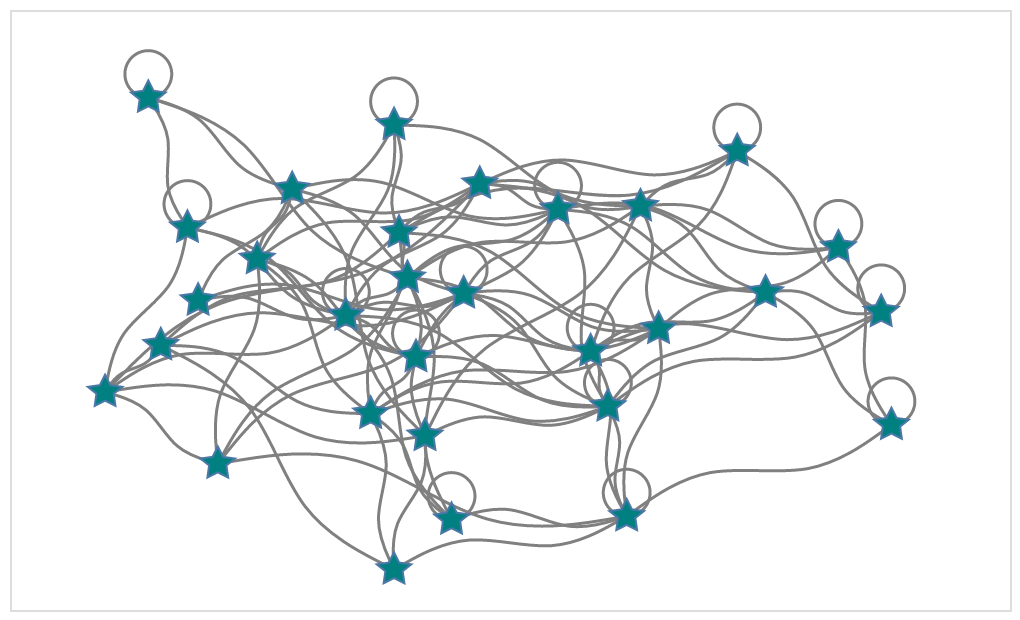

In [10]:
# Some examples from Altair's Point and Line documentation pages

node_shape_select = alt.binding_select(name = 'node shape',
    options = ['arrow', 'circle', 'square', 'cross', 'diamond', 'wedge', 'stroke',
        'triangle', 'triangle-up', 'triangle-down', 'triangle-right', 'triangle-left',
        'M-1,-1H1V1H-1Z', 'M0,.5L.6,.8L.5,.1L1,-.3L.3,-.4L0,-1L-.3,-.4L-1,-.3L-.5,.1L-.6,.8L0,.5Z'
    ]
)
node_shape_var = alt.param(bind = node_shape_select, value = 'M0,.5L.6,.8L.5,.1L1,-.3L.3,-.4L0,-1L-.3,-.4L-1,-.3L-.5,.1L-.6,.8L0,.5Z')

node_size_slider = alt.binding_range(min = 0, max = 500, step = 10, name = 'node size')
node_size_var = alt.param(bind = node_size_slider, value = 300)

edge_width_slider = alt.binding_range(min = 0, max = 10, step = 0.5, name = 'edge width')
edge_width_var = alt.param(bind = edge_width_slider, value = 1.5)

# Pass the bound parameters through the appropriate *_kwargs (and "register" them on the output chart)
anx.draw_networkx(G, pos,
    node_tooltip = ['name', 'importance', 'viable'],
    curved_edges = True, edge_control_points = [(0.333, 0.1), (0.666, -0.1)],
    node_mark_kwargs = dict(shape = node_shape_var, size = node_size_var),
    edge_mark_kwargs = dict(strokeWidth = edge_width_var)
).add_params(node_shape_var, node_size_var, edge_width_var).interactive()